In [8]:
#Import necessary packages

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split 
import re
from bs4 import BeautifulSoup

# Traditional Modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Tools & Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Dataset/')

In [11]:
#Read input excel sheet

df = pd.read_excel("input_data.xlsx", sheet_name=None)

In [12]:
#Get the dataframe from first sheet

dfn = df['Sheet1']

In [13]:
#Lets see head of the dataframe

dfn.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [14]:
#Shape of the dataframe

dfn.shape

(8500, 4)

In [15]:
#Check data types

dfn.dtypes

Short description    object
Description          object
Caller               object
Assignment group     object
dtype: object

In [16]:
#Check for blanks

dfn.isna().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [17]:
#We are more interested in Description column as it clearly looks like superset of short description
#So lets see that row with blank value for Description

dfn[dfn['Description'].isna()]

,Short description,Description,Caller,Assignment group
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [18]:
#Lets fill the description value above with what we have for short description

dfn.iloc[4395, dfn.columns.get_loc('Description')] = dfn.iloc[4395, dfn.columns.get_loc('Short description')]

In [19]:
#Lets check for nulls

dfn.isnull().sum()

Short description    8
Description          0
Caller               0
Assignment group     0
dtype: int64

We will be using Description column data for training, so we can ignore Short description and Caller

In [20]:
dfn = dfn.drop(['Short description'], axis=1)
dfn = dfn.drop(['Caller'], axis=1)

In [21]:
#We noticed there are so many unwanted sequences in Description column
#Lets get rid of those

dfn["Description"] = dfn["Description"].astype(str) 
dfn = dfn.replace('\r\n','', regex=True)

In [22]:
#Remove Date and time from description

dfn["Description"] = dfn["Description"].replace('\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}','', regex=True)

In [23]:
#Remove html characters if any

def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

dfn['Description'] = dfn['Description'].apply(lambda x: strip_html_tags(x))

In [24]:
pip install unidecode

In [25]:
#Remove Accented Characters if any
import unidecode

def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

dfn['Description'] = dfn['Description'].apply(lambda x: remove_accented_chars(x))

In [26]:
pip install -U nltk

Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.5)


In [27]:
#Filter out punctuations

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


def filter_punctuations(text):
    tokens = word_tokenize(text)
    # remove all tokens that are not alphabetic
    words = [word for word in tokens if word.isalpha()]
    return ' '.join(words)

dfn['Description'] = dfn['Description'].apply(lambda x: filter_punctuations(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
#Lowercase the description

dfn['Description'] = dfn['Description'].apply(lambda x: x.lower())

In [29]:
#Remove digits and word containing digits

dfn['Description'] = dfn['Description'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [30]:
#Expand Contractions

# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

dfn['Description'] = dfn['Description'].apply(lambda x:expand_contractions(x))

In [31]:
#Filter out stopwords

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def filter_stopwords(text):
    tokens = word_tokenize(text)
    # remove all tokens that are stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in tokens if not w in stop_words]
    return ' '.join(words)

dfn['Description'] = dfn['Description'].apply(lambda x: filter_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
#Lemmatization

import spacy

# Loading model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

dfn['lemmatized'] = dfn['Description'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x))]))


In [33]:
#Check and remove empty rows after lemmatization

print(dfn.shape)
dfn = dfn[dfn['lemmatized'] != '']
print(dfn.shape)

(8500, 3)
(8430, 3)


In [34]:
#Lets group the lemmatized descriptions based on assignment groups

df_grouped = dfn[['Assignment group','lemmatized']].groupby(by='Assignment group').agg(lambda x:' '.join(x))
df_grouped.head(20)

,lemmatized
Assignment group,
GRP_0,user details employee manager name user name a...
GRP_1,event critical value mountpoint threshold toda...
GRP_10,receive fail receive fail receive fail receive...
GRP_11,hello service nee monitor manufacture drawing ...
GRP_12,c label server space consume space available g...
GRP_13,receive fail receive two customer account get ...
GRP_14,intermittent service configair server require ...
GRP_15,hi channel partner email address djhadkudhd re...
GRP_16,receive cid bwfhtumx japznrvb regional control...


In [35]:
# Lets create Document Term Matrix

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer='word')
data = cv.fit_transform(df_grouped['lemmatized'])

df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index = df_grouped.index
df_dtm.head(10)

,aa,aaa,aaeur,aao,aaymanncustom,ab,abandon,abap,abarbeiten,abc,abca,abcdegy,abcdri,abd,abdhtyu,abend,abende,abended,aber,abertura,abfragetimeout,abgebildet,abgebrochen,abgelaufen,abgeschlossen,abgesprochen,abgrtyreu,abhanden,abhandengekommen,abhay,abhilfe,abholen,abholung,ability,abl,able,abmelden,abode,abort,abovementione,...,zugang,zugordnet,zugriff,zugriffe,zugriffs,zugriffsrechte,zuhause,zuhoylts,zukommen,zulassen,zum,zumindest,zuothryrt,zur,zura,zurtxjbd,zurzeit,zusammen,zuschaltung,zusta,zuteillisten,zuvjqgwa,zuvor,zuyimtsf,zvjxuahe,zvmesjpt,zvnxlobq,zvnxlobqdirecteur,zvygmnco,zwar,zwei,zweites,zwip,zwischen,zwrypjqv,zwutmehy,zwwirep,zxdtskpw,zyjfpgtk,zz
Assignment group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GRP_0,0,2,0,0,1,1,0,2,0,1,0,0,1,1,2,0,0,0,7,0,0,0,1,0,1,0,1,1,0,0,2,0,0,1,1,266,0,0,0,0,...,1,0,18,1,1,0,1,1,0,0,3,0,1,1,8,0,1,4,1,0,1,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,1,0,0
GRP_1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GRP_10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GRP_11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
GRP_12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,9,0,0,0,0,...,0,0,7,0,0,1,0,0,0,1,1,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GRP_13,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GRP_14,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GRP_15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GRP_16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


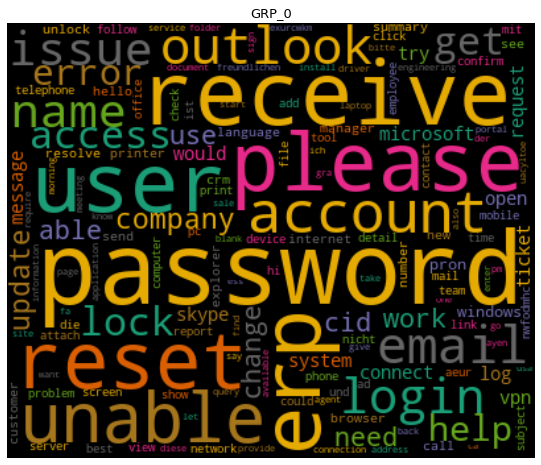

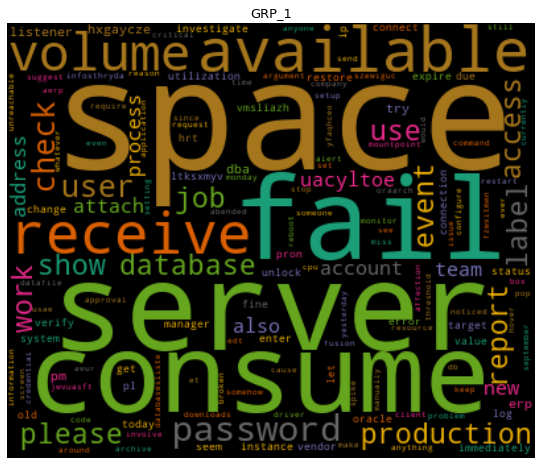

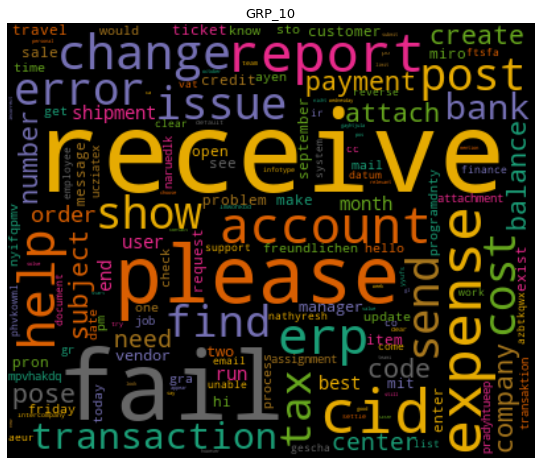

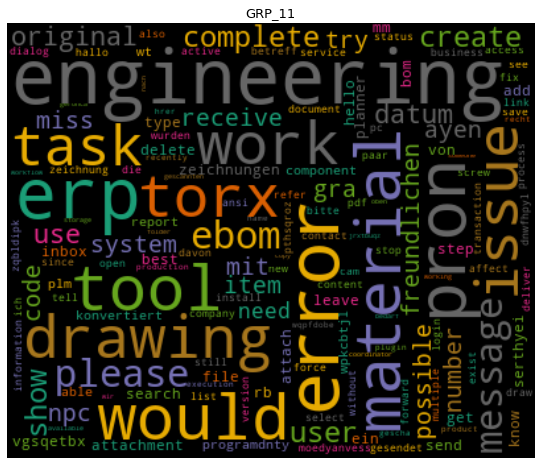

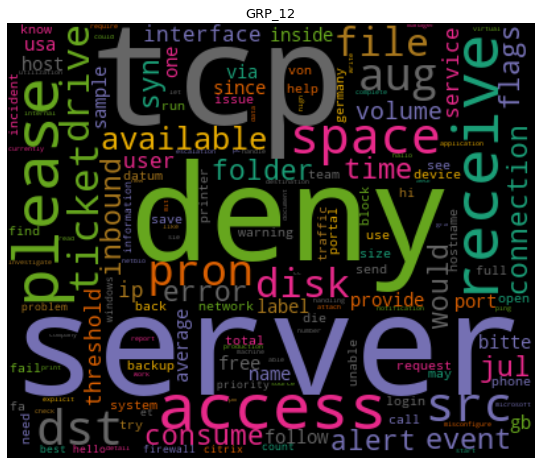

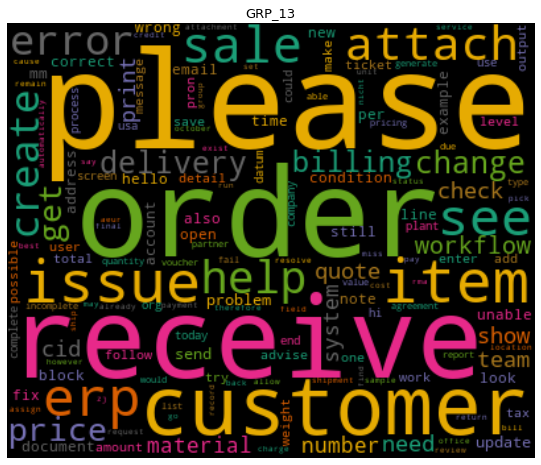

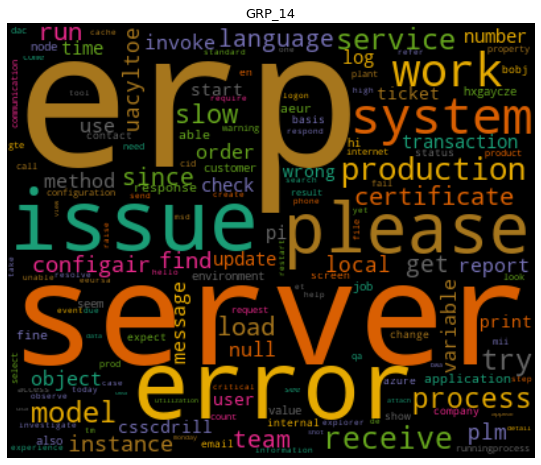

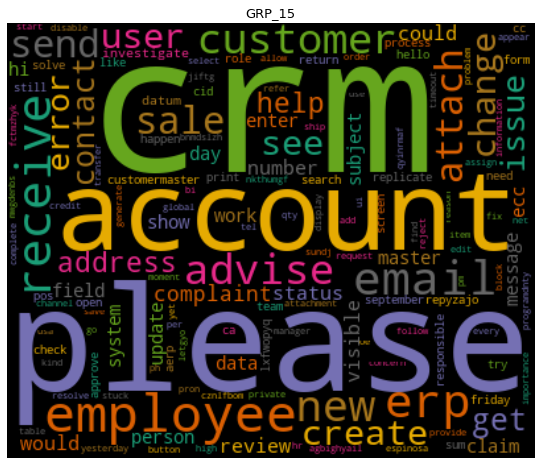

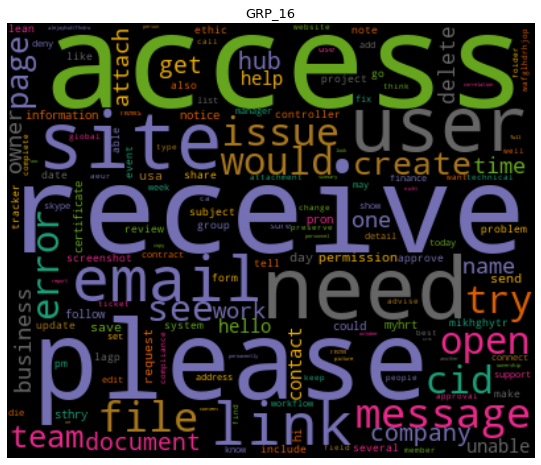

ZeroDivisionError: ignored

In [36]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
df_dtm = df_dtm.transpose()


# Plotting word cloud for each group
for index, group in enumerate(df_dtm.columns):
    generate_wordcloud(df_dtm[group].sort_values(ascending=False), group)

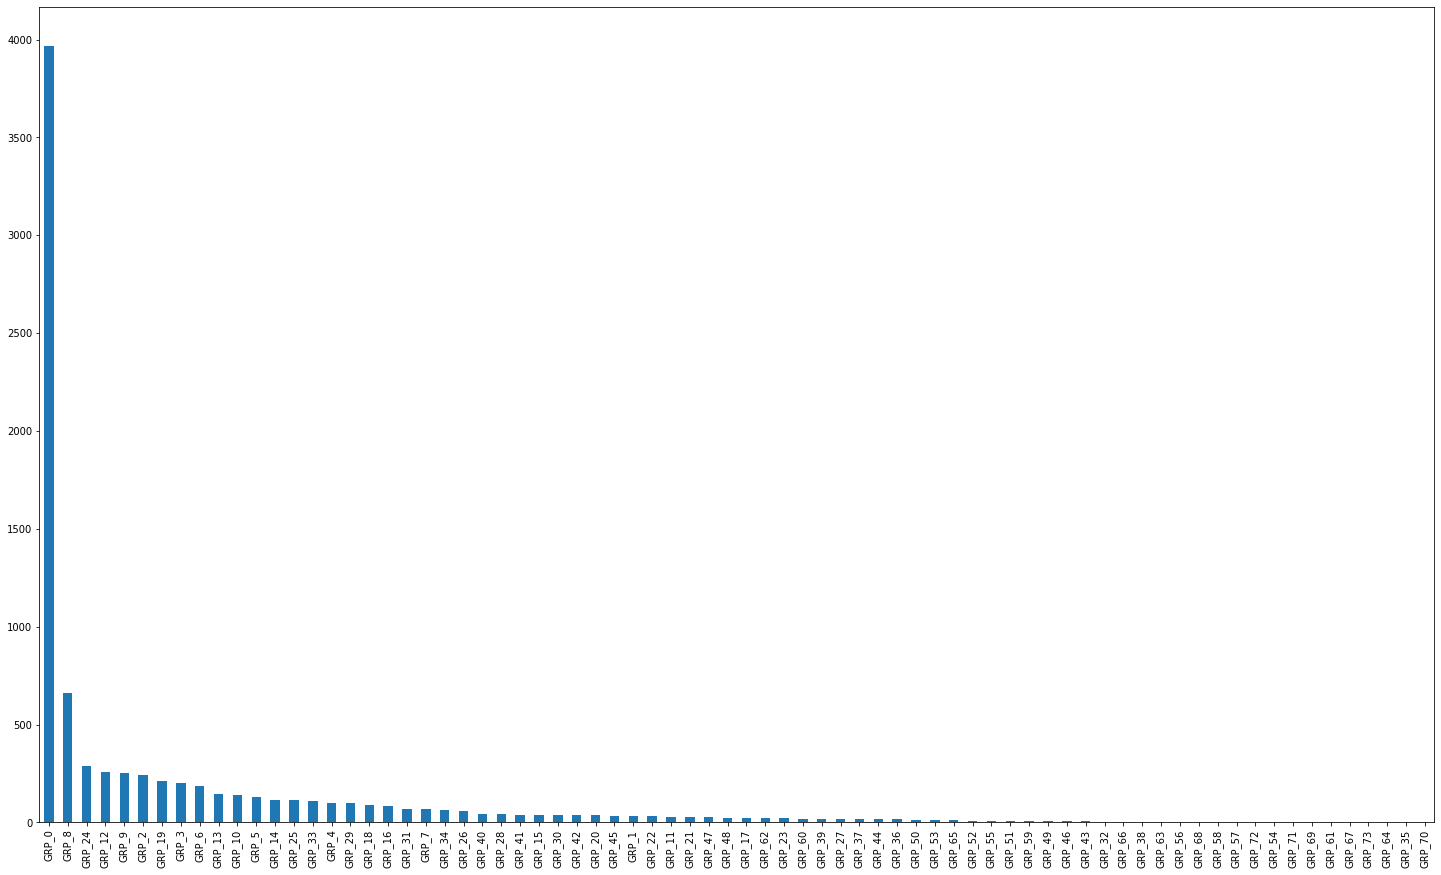

In [37]:
#Lets check how balance our classification is

dfn['Assignment group'].value_counts().plot(kind='bar', figsize=(25,15));

We can see how unbalanced our dataset is. We will try to make use of NLP data augmentation techniques.

In [38]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# Easy data augmentation techniques for text classification

import random
from random import shuffle
random.seed(1)

# stop words list

stop_words = [
    'i',
    'me',
    'my',
    'myself',
    'we',
    'our',
    'ours',
    'ourselves',
    'you',
    'your',
    'yours',
    'yourself',
    'yourselves',
    'he',
    'him',
    'his',
    'himself',
    'she',
    'her',
    'hers',
    'herself',
    'it',
    'its',
    'itself',
    'they',
    'them',
    'their',
    'theirs',
    'themselves',
    'what',
    'which',
    'who',
    'whom',
    'this',
    'that',
    'these',
    'those',
    'am',
    'is',
    'are',
    'was',
    'were',
    'be',
    'been',
    'being',
    'have',
    'has',
    'had',
    'having',
    'do',
    'does',
    'did',
    'doing',
    'a',
    'an',
    'the',
    'and',
    'but',
    'if',
    'or',
    'because',
    'as',
    'until',
    'while',
    'of',
    'at',
    'by',
    'for',
    'with',
    'about',
    'against',
    'between',
    'into',
    'through',
    'during',
    'before',
    'after',
    'above',
    'below',
    'to',
    'from',
    'up',
    'down',
    'in',
    'out',
    'on',
    'off',
    'over',
    'under',
    'again',
    'further',
    'then',
    'once',
    'here',
    'there',
    'when',
    'where',
    'why',
    'how',
    'all',
    'any',
    'both',
    'each',
    'few',
    'more',
    'most',
    'other',
    'some',
    'such',
    'no',
    'nor',
    'not',
    'only',
    'own',
    'same',
    'so',
    'than',
    'too',
    'very',
    's',
    't',
    'can',
    'will',
    'just',
    'don',
    'should',
    'now',
    '',
    ]

# cleaning up text

import re


def get_only_chars(line):

    clean_line = ''

    line = line.replace('\xe2\x80\x99', '')
    line = line.replace("'", '')
    line = line.replace('-', ' ')  # replace hyphens with spaces
    line = line.replace('\t', ' ')
    line = line.replace('\n', ' ')
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +', ' ', clean_line)  # delete extra spaces
    if len(clean_line) > 0 and clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line


########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet


def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word
                            not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [(synonym if word == random_word else word)
                         for word in new_words]

            # print("replaced", random_word, "with", synonym)

            num_replaced += 1
        if num_replaced >= n:  # only replace up to n words
            break

    # this is stupid but we need it, trust me

    sentence = ' '.join(new_words)
    new_words = sentence.split(' ')

    return new_words


def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace('_', ' ').replace('-', ' '
                    ).lower()
            synonym = ''.join([char for char in synonym if char
                              in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)


########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################

def random_deletion(words, p):

    # obviously, if there's only one word, don't delete it

    if len(words) == 1:
        return words

    # randomly delete words with probability p

    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    # if you end up deleting all words, just return a random word

    if len(new_words) == 0:
        rand_int = random.randint(0, len(words) - 1)
        return [words[rand_int]]

    return new_words


########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################

def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words


def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words) - 1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words) - 1)
        counter += 1
        if counter > 3:
            return new_words
    (new_words[random_idx_1], new_words[random_idx_2]) = \
        (new_words[random_idx_2], new_words[random_idx_1])
    return new_words


########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################

def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words


def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words) - 1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words) - 1)
    new_words.insert(random_idx, random_synonym)


########################################################################
# main data augmentation function
########################################################################

def eda(
    sentence,
    alpha_sr=0.1,
    alpha_ri=0.1,
    alpha_rs=0.1,
    p_rd=0.1,
    num_aug=9,
    ri=True,
    rd=True,
    ):

    sentence = get_only_chars(sentence)
    words = sentence.split(' ')
    words = [word for word in words if word is not '']
    num_words = len(words)

    augmented_sentences = []
    num_new_per_technique = int(num_aug / 4) + 1
    n_sr = max(1, int(alpha_sr * num_words))
    n_ri = max(1, int(alpha_ri * num_words))
    n_rs = max(1, int(alpha_rs * num_words))

    # sr
    for _ in range(num_new_per_technique):
        a_words = synonym_replacement(words, n_sr)
        augmented_sentences.append(' '.join(a_words))

    # ri
    if ri:
        for _ in range(num_new_per_technique):
            a_words = random_insertion(words, n_ri)
            augmented_sentences.append(' '.join(a_words))

    # rs
    for _ in range(num_new_per_technique):
        a_words = random_swap(words, n_rs)
        augmented_sentences.append(' '.join(a_words))

    # rd
    if rd:
        for _ in range(num_new_per_technique):
            a_words = random_deletion(words, p_rd)
            augmented_sentences.append(' '.join(a_words))

    augmented_sentences = [get_only_chars(sentence) for sentence in
                           augmented_sentences]
    shuffle(augmented_sentences)

    # trim so that we have the desired number of augmented sentences
    if num_aug >= 1:
        augmented_sentences = augmented_sentences[:num_aug]
    else:
        keep_prob = num_aug / len(augmented_sentences)
        augmented_sentences = [s for s in augmented_sentences
                               if random.uniform(0, 1) < keep_prob]

    # append the original sentence
    augmented_sentences.append(sentence)

    return augmented_sentences

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [39]:
#We dont need Description column anymore

dfn = dfn.drop(['Description'], axis=1)

In [40]:
#Lets augment text for groups other than GRP_0

df_aug = pd.DataFrame(columns=dfn.columns)

for index, row in dfn.iterrows():
  if row['Assignment group'] != 'GRP_0':
      sentences = eda(row['lemmatized'])
      for sentence in sentences:
        df_aug = df_aug.append({'Assignment group': row['Assignment group'], 'lemmatized': sentence}, ignore_index=True)
df_aug.head()

,Assignment group,lemmatized
0,GRP_1,mountpoint critical value event threshold
1,GRP_1,event critical treasure mountpoint threshold
2,GRP_1,event critical value mountpoint threshold
3,GRP_1,room access event critical value mountpoint th...
4,GRP_1,event critical value mountpoint threshold


In [41]:
#Append df_aug to parent dataframe dfn

dfn = dfn.append(df_aug) 

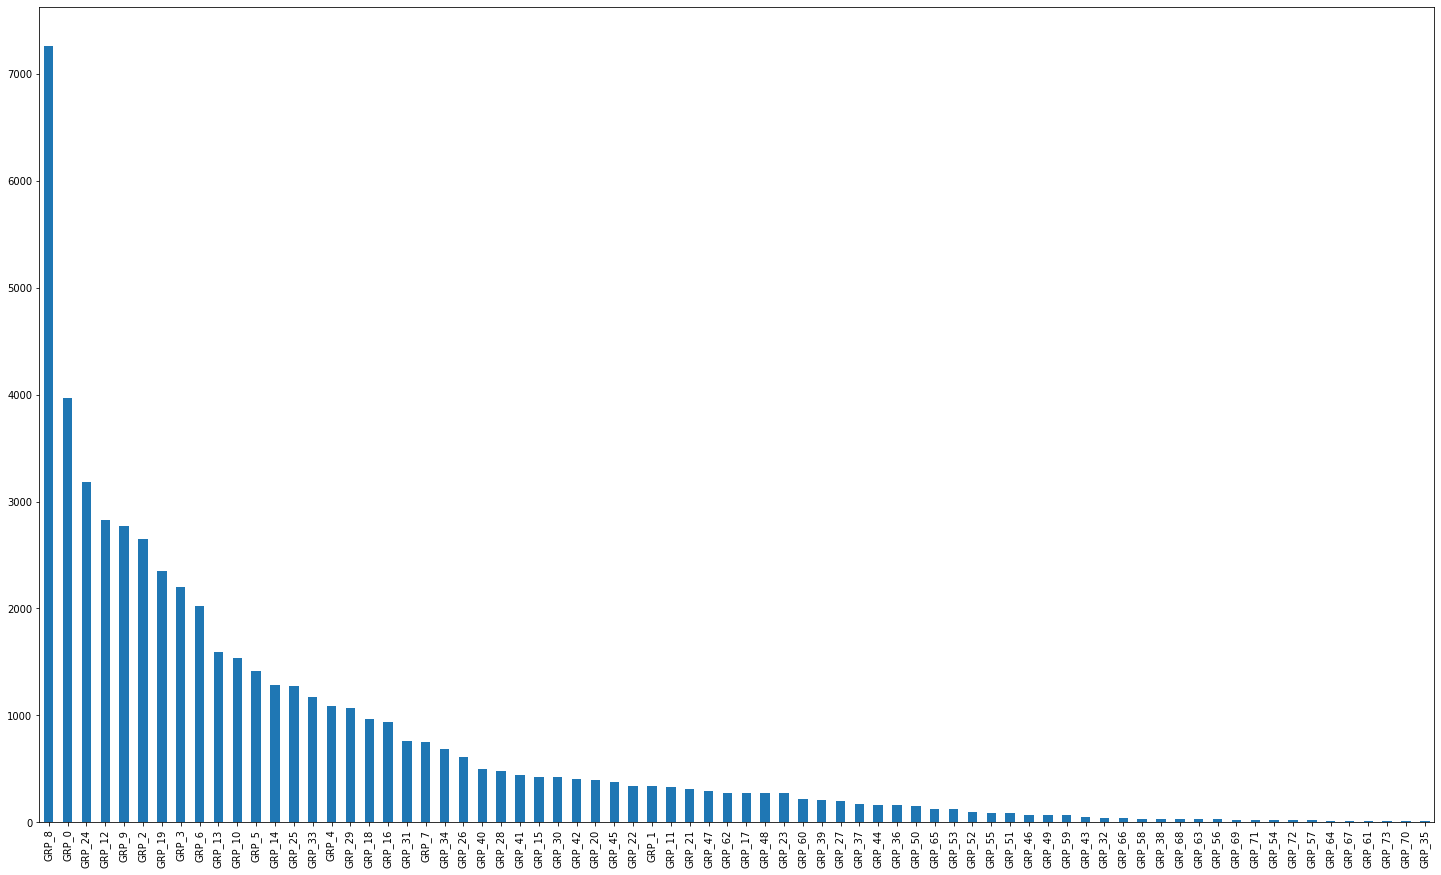

In [42]:
#Lets check classification plot again

dfn['Assignment group'].value_counts().plot(kind='bar', figsize=(25,15));

In [43]:
#Separate train and target columns

X = dfn.drop(['Assignment group'], axis=1)
y = dfn['Assignment group']

In [44]:
#Split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
!!pip uninstall tensorflow
!pip install tensorflow==2.0.0

In [45]:
pip install transformers

In [46]:
import transformers
import numpy as np

txt = "bank river"
## bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
## bert model
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')
## return hidden layer with embeddings
input_ids = np.array(tokenizer.encode(txt))[None,:]  
embedding = nlp(input_ids)
embedding[0][0]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


<tf.Tensor: id=15808, shape=(4, 768), dtype=float32, numpy=
array([[-0.34245932,  0.05200424, -0.25653845, ..., -0.24441805,
         0.0527977 ,  0.44900644],
       [-0.38362464, -0.66715145, -0.35021242, ..., -0.1021051 ,
        -0.21629418, -0.29299945],
       [-0.34996083, -0.08316983, -0.987683  , ...,  0.06963274,
        -0.4945301 , -0.16088377],
       [ 0.7392344 ,  0.07391948, -0.45681012, ..., -0.0241579 ,
        -0.76496637, -0.28110725]], dtype=float32)>

In [47]:
def getSegs(corpus):
  maxlen = 50

  ## add special tokens
  maxqnans = np.int((maxlen-20)/2)
  corpus_tokenized = ["[CLS] "+
              " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
              str(txt).lower().strip()))[:maxqnans])+
              " [SEP] " for txt in corpus]

  ## generate masks
  masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
            txt.split(" "))) for txt in corpus_tokenized]
      
  ## padding
  txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
      
  ## generate idx
  idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
      
  ## generate segments
  segments = [] 
  for seq in txt2seq:
      temp, i = [], 0
      for token in seq.split(" "):
          temp.append(i)
          if token == "[SEP]":
              i += 1
      segments.append(temp)
      
  return idx, masks, segments

In [48]:
#Lets create feature matrix for training set

corpus = X_train["lemmatized"]

idx, masks, segments = getSegs(corpus)
  
## feature matrix
X_train = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

In [49]:
#Do the same for test data

corpus = X_test["lemmatized"]

idx, masks, segments = getSegs(corpus)
  
## feature matrix
X_test = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]


In [50]:
#Build the model

from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model

## inputs
idx = Input((50), dtype="int32", name="input_idx")
masks = Input((50), dtype="int32", name="input_masks")
segments = Input((50), dtype="int32", name="input_segments")

## pre-trained bert
nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased")
bert_out, _ = nlp([idx, masks, segments])

## fine-tuning
x = GlobalAveragePooling1D()(bert_out)
x = Dense(64, activation="relu")(x)
y_out = Dense(len(np.unique(y_train)), activation='softmax')(x)

## compile
model = Model([idx, masks, segments], y_out)

for layer in model.layers[:4]:
    layer.trainable = False

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_2 (TFBertModel)   ((None, 50, 768), (N 109482240   input_idx[0][0]                  
                                                                 input_masks[0][0]            

## **Feature Engineering and Model Building using TF IDF**


## <u>Overview of this step:</u>
We take the lemmatized data and generate various features using TF IDF.
Traditional Ml algorithms for Classification will be applied on this vecotrised features.
Also deep learning models such as Bidirectional LSTM will be used to determine accuracy.
Comparison of the model accuracy for selecting best performing model.

## <u>Model Building</u>
The following algorithms will be used to determine and compare the accuracy.
- Multinomial Naive Bayes
- K Nearest neighbor
- Support Vector Machine
- Decission Tree
- Random Forest
- Deep Neural Network
- Convolutional Neural Network
- Recurrent Neural Network
- Recurrent Convolutional Neural Network
- RNN with LSTM

Let's create another column of categorical datatype from Assignment groups. Let's write some generic methods for utilities and to plot evaluation metrics.

# **Vectorization using TF-IDF or Term Frequency(TF) — Inverse Dense Frequency(IDF)¶**

In [51]:
X = dfn['lemmatized']
y = dfn['Assignment group']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [52]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((39787,), (39787,), (13263,), (13263,))

In [53]:
X_train.head()

34079    receive team erp module two error good receipt...
16374                     outlook plug into connect server
11096                                         receive fail
5649     receive open close manipulate task engineering...
10644                                              drucker
Name: lemmatized, dtype: object

In [54]:
y_train.head()

34079    GRP_29
16374     GRP_3
11096     GRP_5
5649     GRP_25
10644    GRP_24
Name: Assignment group, dtype: object

# **Multinomial Naive Bayes**

In [55]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_train_pred_NB = clf.predict(count_vect.transform(X_train))
y_test_pred_NB = clf.predict(count_vect.transform(X_test))
print("Multinomial NaiveBayers :")
print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred_NB) * 100))
print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_test_pred_NB) * 100))

Multinomial NaiveBayers :
Training accuracy: 65.80%
Testing accuracy: 63.66%


# **K Nearest Neighbor**

In [56]:
clf_knn = KNeighborsClassifier(n_neighbors=7,weights='uniform').fit(X_train_tfidf, y_train)
y_train_pred_knn = clf_knn.predict(count_vect.transform(X_train))
y_test_pred_knn = clf_knn.predict(count_vect.transform(X_test))
print("K Nearest Neighbours :")
print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred_knn) * 100))
print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_test_pred_knn) * 100))

K Nearest Neighbours :
Training accuracy: 85.15%
Testing accuracy: 83.92%



# **Support Vector Machine**

In [57]:
clf_svc = LinearSVC().fit(X_train_tfidf, y_train)
y_train_pred_svc = clf_svc.predict(count_vect.transform(X_train))
y_test_pred_svc = clf_svc.predict(count_vect.transform(X_test))
print("Support Vector Machine :")
print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred_svc) * 100))
print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_test_pred_svc) * 100))

Support Vector Machine :
Training accuracy: 85.74%
Testing accuracy: 83.65%


# **Decision Tree**

In [58]:
clf_tree = DecisionTreeClassifier().fit(X_train_tfidf, y_train)
y_train_pred_tree = clf_tree.predict(count_vect.transform(X_train))
y_test_pred_tree = clf_tree.predict(count_vect.transform(X_test))
print("Decision Tree Classifier :")
print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred_tree) * 100))
print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_test_pred_tree) * 100))

Decision Tree Classifier :
Training accuracy: 50.90%
Testing accuracy: 48.07%


# **RandomForest Classifier**

In [59]:
clf_rand = RandomForestClassifier(n_estimators=100).fit(X_train_tfidf, y_train)
y_train_pred_rand = clf_rand.predict(count_vect.transform(X_train))
y_test_pred_rand = clf_rand.predict(count_vect.transform(X_test))
print("RandomForest Classifier:")
print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred_rand) * 100))
print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_test_pred_rand) * 100))

RandomForest Classifier:
Training accuracy: 84.93%
Testing accuracy: 82.27%


# **AdaBoostClassifier**

In [61]:
from sklearn.ensemble import AdaBoostClassifier  
adaclassifier = AdaBoostClassifier( n_estimators= 100, learning_rate=0.1, random_state=22) 
adaclassifier = adaclassifier.fit(X_train_tfidf, y_train) 
y_train_pred_ad = adaclassifier.predict(count_vect.transform(X_train))
y_test_pred_ad = adaclassifier.predict(count_vect.transform(X_test))
print("Adaboost Classifier:")
print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred_ad) * 100))
print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_test_pred_ad) * 100))

Adaboost Classifier:
Training accuracy: 19.70%
Testing accuracy: 19.26%


# **BaggingClassifier**

In [63]:
from sklearn.ensemble import BaggingClassifier  
bgclassifier = BaggingClassifier(n_estimators=150, max_samples= .7, bootstrap=True, oob_score=True, random_state=22) 
bgclassifier = bgclassifier.fit(X_train_tfidf, y_train) 
y_train_pred_bgc = bgclassifier.predict(count_vect.transform(X_train))
y_test_pred_bgc = bgclassifier.predict(count_vect.transform(X_test))
print("Bagging Classifier:")
print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred_bgc) * 100))
print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_test_pred_bgc) * 100))

Bagging Classifier:
Training accuracy: 56.79%
Testing accuracy: 54.32%



# **Comparing Classification Models**

In [64]:

# Comparing models
models = []
models.append(('MNB', MultinomialNB()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=7)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier(n_estimators=100)))
models.append(('SVM', LinearSVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X_train_tfidf, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

MNB: 0.614749 (0.006568)
KNN: 0.803654 (0.015356)
CART: 0.799156 (0.004338)
RFC: 0.859653 (0.003497)
SVM: 0.845025 (0.004449)


# **LSTM Model**

In [65]:
texts = dfn['lemmatized'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
df['token_text_vocab'] = tokenizer.texts_to_sequences(texts)

vocab_words = tokenizer.word_index.items()
len(vocab_words)

#Get the vocabulary size
num_words = len(tokenizer.word_index) +1
print (num_words)


#To view the 10 elements from dictionary
from itertools import islice
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

take(5, vocab_words)

maxlen=300
max_features = 10000

X = tokenizer.texts_to_sequences(dfn['lemmatized'])
X = pad_sequences(X, padding='post',maxlen = maxlen)
# Converting categorical labels to numbers.
y = pd.get_dummies(dfn['Assignment group']).values


print("Number of Samples:", len(X))
print("Number of Labels: ", len(y))



14001
Number of Samples: 53050
Number of Labels:  53050
